In [1]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
from unyt import Myr, K, kpc, Angstrom


In [2]:
# set style
# plt.style.use('../../matplotlibrc.txt')

### Read in Galaxy object

In [3]:
import pickle

# Define object ID
id = '145492'

# Initialise Galaxy object
galaxy = pickle.load(open(f'data/galaxy_{id}.pck','rb'))

## Make an image of various physical properties

In [4]:
# Define the width of the image
width = 2 * kpc

# Define image resolution (here we arbitrarily set it to
# 200 pixels along an axis)
resolution = width / 50

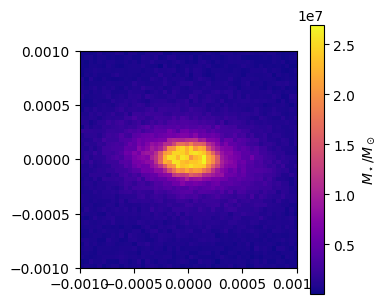

In [5]:

# Make the stellar mass map
stellar_mass_map = galaxy.get_map_stellar_mass(
    resolution=resolution,
    fov=width,
    img_type="hist",
)

fig, ax = stellar_mass_map.plot_map(
    show=True,
    cmap="plasma",
    cbar_label=r"$M_\star/M_\odot$",
)
plt.close(fig)

## Rest-frame luminosity Figure

Define the photometric filters

In [6]:
from synthesizer.filters import Filter, FilterCollection

tophats = {
    "U": {"lam_eff": 3650 * Angstrom, "lam_fwhm": 660 * Angstrom},
    "V": {"lam_eff": 5510 * Angstrom, "lam_fwhm": 880 * Angstrom},
    "J": {"lam_eff": 12200 * Angstrom, "lam_fwhm": 2130 * Angstrom},
}

filters = FilterCollection(
    tophat_dict=tophats,
    new_lam=np.arange(3000, 15000, 100) * Angstrom
)

print(filters.lam.size)

120


/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_58826/1733379677.py:1: FutureWarning: The filters module has been moved to the instruments module. Please update your imports synthesizer.filters -> synthesizer.instruments
  from synthesizer.filters import Filter, FilterCollection


Generate the photometry for every single star particle.

In [7]:
from synthesizer.grid import Grid
from synthesizer.emission_models import ScreenEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody

# define grid_dir and grid_name
grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps'


# initialise the grid, but with a restricted wavelength range and resolution
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=filters.lam)

In [8]:

# specify a power-law dust curve
alpha = -1.0 # dust curve slope
dust_curve = PowerLaw(slope=alpha)

# Define the emission model, in this case Screen emission which just allows you to define tau_v for each particle
emission_model = ScreenEmission(
    grid=grid, 
    tau_v="tau_v", 
    # tau_v=0.5, 
    dust_curve=dust_curve,
    fesc=0.0,
    fesc_ly_alpha=1.0,
    per_particle=True
    )

In [9]:

# generate the spectra of every star particle
galaxy.stars.get_spectra(emission_model)

# generate the photometry
galaxy.get_photo_lnu(filters)

MissingAttribute: fesc can't be found on the model (escaped), emission (Sed), or emitter (Stars).  [EmissionModel.label: escaped] 

Define the image geometry

In [ ]:
# Define the width of the image
width = 3 * kpc

# Define image resolution (here we arbitrarily set it to 100
# pixels along an axis)
resolution = width / 50

print(
    "Image width is %.2f kpc with %.2f kpc resolution"
    % (width.value, resolution.value)
)

In [ ]:
# Get the image
hist_imgs = galaxy.get_images_luminosity(
    resolution=resolution,
    fov=width,
    emission_model=emission_model,
    img_type="hist",
    limit_to="attenuated",
)

In [ ]:

for img in hist_imgs:
    img.plot_img(show=True)

### Create RGB image

In [ ]:
import matplotlib.colors as cm

rgb_img = hist_imgs.make_rgb_image(
    rgb_filters={
        'R': 'J',
        'G': 'V',
        'B': 'U',
    },
)

# Set up minima and maxima
vmin = -np.percentile(rgb_img, 32)
vmax = np.percentile(rgb_img, 99.9)
norm = cm.Normalize(vmin=vmin, vmax=vmax, clip=True)
print("Scaling to:", vmin, "->", vmax)

# Normalise the image.
rgb_img = norm(rgb_img)

print(rgb_img.shape)

# Plot the image
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(rgb_img, origin="lower", interpolation="nearest")
ax.axis("off")
plt.show()
plt.close(fig)

## More complex property map figures

In [ ]:
from scipy.stats import binned_statistic_2d
from matplotlib import cm
from matplotlib.colors import Normalize

radius=15
bins=50
pixel_size = radius*2./bins # kpc
pixel_area = pixel_size**2
pixel_area_pc2 = pixel_area * 1000**2
print(pixel_area_pc2)

def add_weighted_histogram(ax, x, y, q, cmap_name='viridis', label=None, log10=False, vmin=0.0, vmax=None):

    if cmap_name.split('.')[0] == 'cmr':
        cmap = cmr.get_sub_cmap(cmap_name, 0, 1)
    else:
        cmap = cm.get_cmap(cmap_name)

    cmap.set_bad(color='0.5')

    range = [(-radius, radius),(-radius, radius)]

    hist, xedges, yedges = np.histogram2d(
        x, 
        y, 
        weights=q, 
        range=range, 
        bins=bins,)
    
    hist /= pixel_area_pc2

    if log10 is True:
        hist = np.log10(hist)

    # selection = hist == hist
    # if not vmin:
    #     vmin = np.min(hist[selection])
    if not vmax:
        if log10 is True:
            vmax = np.round(np.max(hist),1)+0.5
            vmin = vmax - 4.
        else:
            vmax = np.max(hist)
            vmin = 0.0

    # hist[hist==-np.inf] = vmin

    norm = Normalize(vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='top', orientation='horizontal', pad=0.0, fraction=0.2)

    cbar.set_label(label=label,fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    ax.imshow(hist, cmap=cmap, vmin=vmin, vmax=vmax)

    return ax 


def add_ratio(ax, x, y, q1, q2, cmap_name='viridis', label=None, log10=False, vmin=0.0, vmax=None):

    if cmap_name.split('.')[0] == 'cmr':
        cmap = cmr.get_sub_cmap(cmap_name, 0, 1)
    else:
        cmap = cm.get_cmap(cmap_name)

    cmap.set_bad(color='0.5')

    range = [(-radius, radius),(-radius, radius)]

    hist1, xedges, yedges = np.histogram2d(
        x, 
        y, 
        weights=q1, 
        range=range, 
        bins=bins,)
    
    hist2, xedges, yedges = np.histogram2d(
        x, 
        y, 
        weights=q2, 
        range=range, 
        bins=bins,)
    
    ratio = hist1/hist2

    if log10 is True:
        ratio = np.log10(ratio)

    if not vmax:
        if log10 is True:
            vmax = np.round(np.max(ratio),1)+0.5
            vmin = vmax - 4.
        else:
            vmax = np.max(ratio)
            vmin = 0.0

    norm = Normalize(vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='top', orientation='horizontal', pad=0.0, fraction=0.2)

    cbar.set_label(label=label,fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    ax.imshow(ratio, cmap=cmap, vmin=vmin, vmax=vmax)

    return ax 



def add_binned_statistic(fig, ax, x, y, q, cmap_name='viridis', statistic='median', label=None, log10=False, vmin=None, vmax=None):

    if cmap_name.split('.')[0] == 'cmr':
        cmap = cmr.get_sub_cmap(cmap_name, 0, 1)
    else:
        cmap = cm.get_cmap(cmap_name)

    cmap.set_bad(color='0.5')

    range = [(-radius, radius),(-radius, radius)]

    statistic, xedges, yedges, N = binned_statistic_2d(x, y, q, statistic=statistic, bins=bins, range=range)

    if log10 is True:
        statistic = np.log10(statistic)

    if not vmin:
        vmin = np.min(statistic)
    if not vmax:
        vmax = np.max(statistic)

    norm = Normalize(vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='top', orientation='horizontal', pad=0.0, fraction=0.2)

    cbar.set_label(label=label,fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    ax.imshow(statistic, cmap=cmap, vmin=vmin, vmax=vmax)

    return ax 

In [ ]:

# convert to kpc
x = galaxy.stars.centered_coordinates[:, 0].to('kpc').value 
y = galaxy.stars.centered_coordinates[:, 1].to('kpc').value 
z = galaxy.stars.centered_coordinates[:, 2].to('kpc').value 


g_x = galaxy.gas.centered_coordinates[:, 0].to('kpc').value 
g_y = galaxy.gas.centered_coordinates[:, 1].to('kpc').value 
g_z = galaxy.gas.centered_coordinates[:, 2].to('kpc').value 

print(x)
print(len(g_x))
print(len(x))

In [ ]:
N = 5
size = 2

gridspec_kw = {'left': 0.0, 'right': 1.0, 'top': 1.0, 'bottom': 0.0, 'wspace': 0.0, 'hspace': 0.0 }

fig, axes = plt.subplots(1, N, gridspec_kw=gridspec_kw, figsize=(N*size, size*1.25))

for ax in axes:
    ax.axis('off')

# add stellar mass
add_weighted_histogram(axes[0], x, y, galaxy.stars._initial_masses, label=r'$\log_{10}(\Sigma_{\star}/M_{\odot}\ pc^{-2})$', log10=True, cmap_name='cmr.gem')

#  add median metallicity
add_binned_statistic(fig, axes[1], x, y, galaxy.stars.metallicities, label=r'$\log_{10}\left(\langle Z\rangle\right)$', log10=True, vmin=-2.9, vmax=-1.1, cmap_name='cmr.gem')

# add median age
add_binned_statistic(fig, axes[2], x, y, galaxy.stars._ages, label=r'$\log_{10}(age/yr)$', log10=True, vmin=7.76, vmax=10.4, cmap_name='cmr.guppy')

# add recent star formation
timescale = 10
selection = galaxy.stars.ages.to('Myr').value < timescale
add_weighted_histogram(axes[3], x[selection], y[selection], galaxy.stars._initial_masses[selection]/timescale, label=r'$\log_{10}(\Sigma_{SFR_{10}}/M_{\odot}\ yr^{-1}\ pc^{-2})$', log10=True, cmap_name='cmr.torch')

# add median metallicity
add_binned_statistic(fig, axes[4], x[selection], y[selection], galaxy.stars.metallicities[selection], label=r'$\log_{10}\left(\langle Z\rangle_{age<10\ Myr}\right)$', log10=True, vmin=-2.9, vmax=-1.1, cmap_name='cmr.gem')

fig.show()
# fig.savefig('figs/tng_map_physical.png')

#### Gas distribution maps

In [ ]:
N = 3
size = 2

gridspec_kw = {'left': 0.0, 'right': 1.0, 'top': 1.0, 'bottom': 0.0, 'wspace': 0.0, 'hspace': 0.0 }

fig, axes = plt.subplots(1, N, gridspec_kw=gridspec_kw, figsize=(N*size, size*1.25))

for ax in axes:
    ax.axis('off')



# add gas surface density
add_weighted_histogram(axes[0], g_x, g_y, galaxy.gas.masses.value, label='$\log_{10}(\Sigma_{g}/M_{\odot}\ pc^{-2})$', log10=True, cmap_name='magma')

# add metal surface density
add_weighted_histogram(axes[1], g_x, g_y, galaxy.gas.masses.value*galaxy.gas.metallicities, label='$\log_{10}(\Sigma_{Z}/M_{\odot}\ pc^{-2})$', log10=True, cmap_name='magma')

# add median attenuation
add_binned_statistic(fig, axes[2], x, y, galaxy.stars.tau_v, label=r'$\log_{10}\left(\langle\tau_{V}\rangle\right)$', log10=True, vmin=-2.9, vmax=1.5, cmap_name='cmr.sunburst_r')

fig.show()
# fig.savefig('figs/tng_map_dust.png')

### Initialise a SPS grid

In [ ]:
from synthesizer.grid import Grid

grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps'

# initialise the grid, but with a restricted wavelength range and resolution
grid = Grid(grid_name, grid_dir=grid_dir)